## LANL Earthquake Prediction

In this competition, you will address when the earthquake will take place. Specifically, you’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data.

### Prepare the data analysis

In [1]:
import gc
import os
import time
import zipfile
import logging
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

from scipy import stats
from scipy.signal import hann
from scipy.signal import hilbert
from scipy.signal import convolve

from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
%%time
zip_file = zipfile.ZipFile('/Users/mathvan/Documents/anaconda/Kaggle/EarthQuakes/train.csv.zip') 
train_df = pd.read_csv(zip_file.open('train.csv'), 
                       dtype={'acoustic_data': np.int16, 
                              'time_to_failure': np.float32})

CPU times: user 1min 58s, sys: 26.1 s, total: 2min 24s
Wall time: 2min 38s


In [3]:
print("Train: rows: {}; cols: {}".format(train_df.shape[0], 
                                      train_df.shape[1]))

Train: rows: 629145480; cols: 2


Pfff.. На пару порядков больше, чем я когда-либо видел..

In [4]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


### Data exploration

The dimmension of the data is quite large, in excess of 600 millions rows of data.
<br>The two columns in the train dataset have the following meaning:

- accoustic_data: is the accoustic signal measured in the laboratory experiment;
- time to failure: this gives the time until a failure will occurs.

Let's plot 1% of the data. For this we will sample every 100 points of data:

In [5]:
def plot_acc_ttf_data(train_ad_sample_df, 
                      train_ttf_sample_df, 
                      title="Acoustic data and time to failure: 1% sampled data"):
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

CPU times: user 1.51 s, sys: 3.79 s, total: 5.3 s
Wall time: 6 s


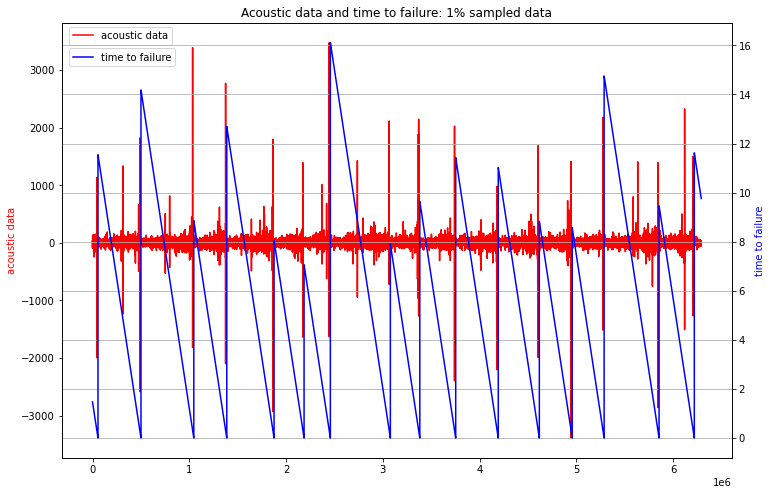

In [6]:
%%time
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

plot_acc_ttf_data(train_ad_sample_df, 
                  train_ttf_sample_df)

del train_ad_sample_df
del train_ttf_sample_df

The plot shows only 1% of the full data. The acoustic data shows complex oscilations with variable amplitude. Just before each failure there is an increase in the amplitude of the acoustic data. We see that large amplitudes are also obtained at different moments in time (for example about the mid-time between two succesive failures).

Let's plot as well the first 1% of the data:

CPU times: user 576 ms, sys: 336 ms, total: 912 ms
Wall time: 986 ms


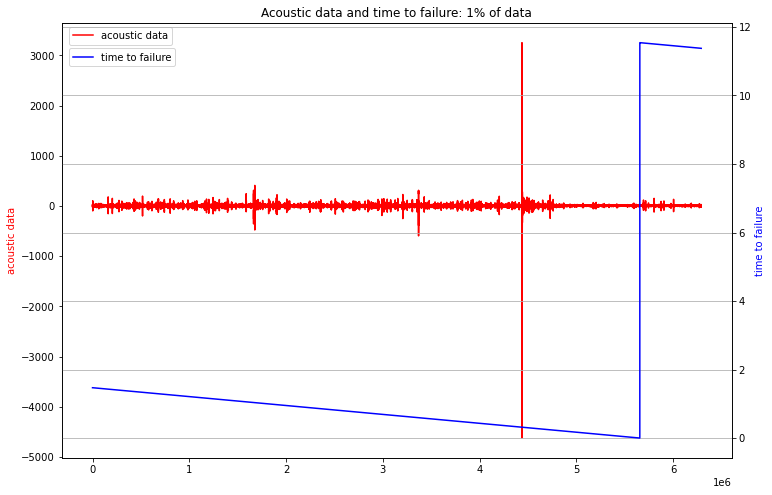

In [7]:
%%time
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]

plot_acc_ttf_data(train_ad_sample_df, 
                  train_ttf_sample_df, 
                  title="Acoustic data and time to failure: 1% of data")

del train_ad_sample_df
del train_ttf_sample_df

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.

---

### Features engineering

The test segments are 150,000 each.
We split the train data in segments of the same dimmension with the test sets.

We will create additional aggregation features, calculated on the segments.

In [8]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments:", segments)

Number of segments: 4194


Let's define some computation helper functions:

In [9]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
        
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    
    return sta / lta

Now let's calculate the aggregated functions for train set:

In [10]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

print("total_mean: {}\ntotal_std: {}\ntotal_max: {}\ntotal_min: {}\ntotal_sum: {}\ntotal_abs_sum: {}".\
      format(total_mean, total_std, total_max, total_min, total_sum, total_abs_sum))

total_mean: 4.519467573700124
total_std: 10.735707249510964
total_max: 5444
total_min: -5515
total_sum: 2843402596
total_abs_sum: 3490177082


In [11]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    ## Проблемы с xc
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    #X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    #X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    #X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    #X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    #X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + \
                                             no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - \
                                            no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + \
                                             no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - \
                                            no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / \
                                                                                       x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / \
                                                                                        x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [12]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows : seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Let's check the result. We plot the shape and the head of train_X:

In [13]:
train_X.shape

(4194, 149)

In [14]:
train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113,5.101106,104.0,-98.0,1.200000e+01,2349.811482,732617.0,-20121.154171,-4.365575e-16,1399.854635,...,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-1.704698e-06,74222.343443,5.629
1,4.725767,6.588824,181.0,-154.0,5.000000e+00,2566.032248,708865.0,-31056.675076,1.455192e-15,1810.312266,...,0.231587,5.667,3.412,4.233,4.345,5.066,5.223,-2.449664e-06,74364.426478,5.667
2,4.906393,6.967397,140.0,-106.0,5.000000e+00,2683.549049,735959.0,-27654.557067,-1.940255e-16,1921.220576,...,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,1.140940e-06,74594.984584,5.957
3,4.902240,6.922305,197.0,-199.0,5.000000e+00,2685.788525,735336.0,-25622.393604,5.335702e-16,1891.826366,...,0.266700,5.858,3.722,4.304,4.433,5.317,5.453,-2.550336e-06,74333.143623,5.858
4,4.908720,7.301110,145.0,-126.0,1.200000e+01,2761.715771,736308.0,-26271.075117,-2.910383e-15,1995.742969,...,0.228005,6.078,3.918,4.434,4.543,5.306,5.491,1.550336e-06,74428.435969,6.078
5,4.913513,5.434111,142.0,-144.0,1.400000e+01,2420.968091,737027.0,-24168.435450,-5.820766e-16,1479.700814,...,0.293941,5.838,4.042,4.270,4.422,5.402,5.620,-3.697987e-06,74539.909434,5.838
6,4.855660,5.687823,120.0,-78.0,-8.246085e-16,2437.523641,728349.0,-23876.893136,-3.880511e-16,1564.532358,...,0.219472,5.546,3.958,4.285,4.504,5.214,5.370,-1.140940e-07,74501.904751,5.546
7,4.505427,5.854512,139.0,-134.0,3.000000e+00,2361.259304,675814.0,-25427.499452,-3.031649e-16,1615.715786,...,0.218514,5.180,3.489,4.040,4.148,4.863,4.953,-1.395973e-06,74515.926219,5.180
8,4.717833,7.789643,168.0,-156.0,1.000000e+00,2805.303460,707675.0,-34542.227581,-5.093170e-16,2137.915924,...,0.240917,5.717,3.933,4.158,4.315,5.104,5.337,2.221477e-06,74464.251035,5.717
9,4.730960,6.890459,152.0,-126.0,5.000000e+00,2620.173754,709644.0,-23173.271872,-2.910383e-16,1900.967780,...,0.258462,5.423,3.832,4.190,4.301,5.128,5.261,5.127517e-06,74344.216475,5.423


We scale the data:

In [15]:
%%time
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

CPU times: user 26.4 ms, sys: 13 ms, total: 39.4 ms
Wall time: 41.7 ms


In [16]:
scaled_train_X.head(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.218194,0.193218,1.199316,-0.105007,1.424140,0.156736,-0.237183,-0.169052,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-1.832422,-0.004742
1,0.805716,0.004734,0.063936,-0.018037,0.078886,-0.008599,0.805716,-0.222118,0.704281,0.007212,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.890022,0.007341
2,1.511155,0.049252,-0.086289,0.163039,0.078886,0.043800,1.511155,-0.104254,-0.116483,0.054839,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.639209,0.099556
3,1.494934,0.043950,0.122560,-0.187796,0.078886,0.044798,1.494934,-0.033851,0.245619,0.042217,...,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,-1.097513,0.068076
4,1.520242,0.088495,-0.067969,0.087590,1.199316,0.078652,1.520242,-0.056324,-1.468329,0.086842,...,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,-0.465464,0.138032
5,1.538962,-0.131054,-0.078961,0.019687,1.519439,-0.073279,1.538962,0.016521,-0.309604,-0.134763,...,0.257139,0.061716,0.239714,0.699393,1.120525,1.741324,1.193167,-1.382506,0.273910,0.061716
6,1.313016,-0.101219,-0.159569,0.268667,-0.721422,-0.065898,1.313016,0.026621,-0.213043,-0.098334,...,-0.218670,-0.031134,0.204367,0.730609,1.416341,1.059323,0.627166,-0.031853,0.021835,-0.031134
7,-0.054824,-0.081617,-0.089953,0.057411,-0.241237,-0.099902,-0.054824,-0.027099,-0.170798,-0.076354,...,-0.224790,-0.147515,0.007014,0.220737,0.132067,-0.213989,-0.316925,-0.514952,0.114836,-0.147515
8,0.774732,0.145944,0.016304,-0.025582,-0.561360,0.098087,0.774732,-0.342873,-0.273393,0.147895,...,-0.081653,0.023240,0.193847,0.466308,0.734522,0.660279,0.552453,0.848347,-0.227912,0.023240
9,0.825999,0.040205,-0.042321,0.087590,0.078886,0.015542,0.825999,0.050997,-0.164763,0.046142,...,0.030453,-0.070246,0.151347,0.532904,0.684017,0.747343,0.380389,1.943539,-1.024070,-0.070246


### Process test data

We apply the same processing done for the training data to the test data:

In [56]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, 
                      dtype=np.float64, 
                      index=submission.index)

In [57]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


Let's check the shape of the submission and test_X datasets:

In [18]:
submission.shape, test_X.shape

((2624, 1), (2624, 149))

In [21]:
zip_file = zipfile.ZipFile('/Users/mathvan/Documents/anaconda/Kaggle/EarthQuakes/test.zip') 
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv(zip_file.open(seg_id + '.csv'))
    create_features(seg_id, seg, test_X)

We scale also the test data:

In [22]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), 
                             columns=test_X.columns)

In [23]:
scaled_test_X.shape

(2624, 149)

In [24]:
scaled_test_X.tail(10)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2614,-1.081635,-0.268602,-0.350098,0.329025,-0.081176,-0.256058,-1.081635,0.296095,-0.357884,-0.265117,...,-0.131863,-0.197756,0.067609,-0.245433,-0.755381,-0.834321,-0.568229,-0.621183,-0.332743,-0.197756
2615,-0.734695,-0.320940,-0.390402,0.400701,0.559070,-0.271491,-0.734695,0.457525,0.100778,-0.320648,...,-0.090274,-0.210476,-0.012763,-0.420247,-0.632725,-0.772650,-0.620301,0.066790,0.379958,-0.210476
2616,-2.073322,0.185999,0.045616,0.027232,0.238947,0.058193,-2.073322,-0.198273,0.173199,0.182882,...,-0.335397,-0.255311,-0.100709,-0.919714,-1.650043,-2.114888,-1.421759,-0.681887,-0.455030,-0.255311
2617,-0.427930,-0.291596,-0.196209,0.310163,0.238947,-0.242327,-0.427930,0.412108,-0.237183,-0.293676,...,-0.306298,-0.147833,0.084020,-0.076863,-0.026663,-0.547735,-0.409749,0.491714,0.259854,-0.147833
2618,-3.374742,-0.152003,-0.298802,0.234715,-0.721422,-0.249114,-3.374742,0.271952,0.462880,-0.156717,...,-0.176298,-0.424477,-0.208012,-1.854134,-3.157983,-3.239465,-2.157561,-0.466895,-0.517983,-0.424477
2619,-1.654729,-0.172408,-0.339106,0.374294,-1.041545,-0.215590,-1.654729,0.224509,0.293899,-0.166937,...,-0.035383,-0.240684,-0.014025,-0.663737,-1.487705,-1.469163,-0.817270,0.643473,-0.554973,-0.240684
2620,-1.487886,-0.060793,0.001648,-0.221748,0.238947,-0.124402,-1.487886,0.230258,-0.599285,-0.063658,...,0.301725,-0.128754,-0.147417,-1.354667,-2.028832,-1.425631,-0.894246,1.559084,-0.820949,-0.128754
2621,-3.010670,0.343255,0.536595,-0.580128,-0.241237,0.174258,-3.010670,-0.487618,0.173199,0.340983,...,-0.166315,-0.130344,-0.335933,-1.564859,-2.624072,-2.956507,-1.935688,1.604611,-0.954385,-0.130344
2622,-0.694312,0.782097,0.727124,-0.640486,-0.241237,0.628382,-0.694312,-1.113687,-0.937247,0.778367,...,-0.045220,0.055357,-0.178977,-0.303704,-0.679623,-0.761767,0.006828,0.916639,1.362109,0.055357
2623,-1.248764,-0.349888,-0.331778,0.347887,0.238947,-0.306139,-1.248764,0.388180,0.167164,-0.350400,...,-0.256028,-0.247997,0.047831,-0.497248,-0.971831,-1.273268,-0.815006,-0.557950,-0.001932,-0.247997


---

### Model: LGBMRegressor

Let's prepare the model:

In [25]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

train_columns = scaled_train_X.columns.values

In [26]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

Run the model.

During training for each fold, we validate using the validation set and also we predict using the current model for test set. The final result will be the average over the all folds for the predictions done at each fold training:

In [27]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()

In [30]:
%%time
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    print('---------------')
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits
    
print('------------------------------')

---------------
fold 0
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.95927	valid_1's l1: 2.25604
[2000]	training's l1: 1.5706	valid_1's l1: 2.12731
[3000]	training's l1: 1.34282	valid_1's l1: 2.10339
[4000]	training's l1: 1.16936	valid_1's l1: 2.09998
Early stopping, best iteration is:
[3754]	training's l1: 1.20858	valid_1's l1: 2.09963
---------------
fold 1
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.95232	valid_1's l1: 2.27262
[2000]	training's l1: 1.56438	valid_1's l1: 2.14245
[3000]	training's l1: 1.34045	valid_1's l1: 2.1173
[4000]	training's l1: 1.16823	valid_1's l1: 2.11147
[5000]	training's l1: 1.02654	valid_1's l1: 2.11046
Early stopping, best iteration is:
[4755]	training's l1: 1.05878	valid_1's l1: 2.11023
---------------
fold 2
Training until validation scores don't improve for 500 rounds
[1000]	training's l1: 1.95955	valid_1's l1: 2.27733
[2000]	training's l1: 1.57459	valid_1's l1: 2.11087
[

Let's print features importance:

<AxesSubplot:title={'center':'LightGBM Features (averaged over folds)'}, xlabel='importance', ylabel='Feature'>

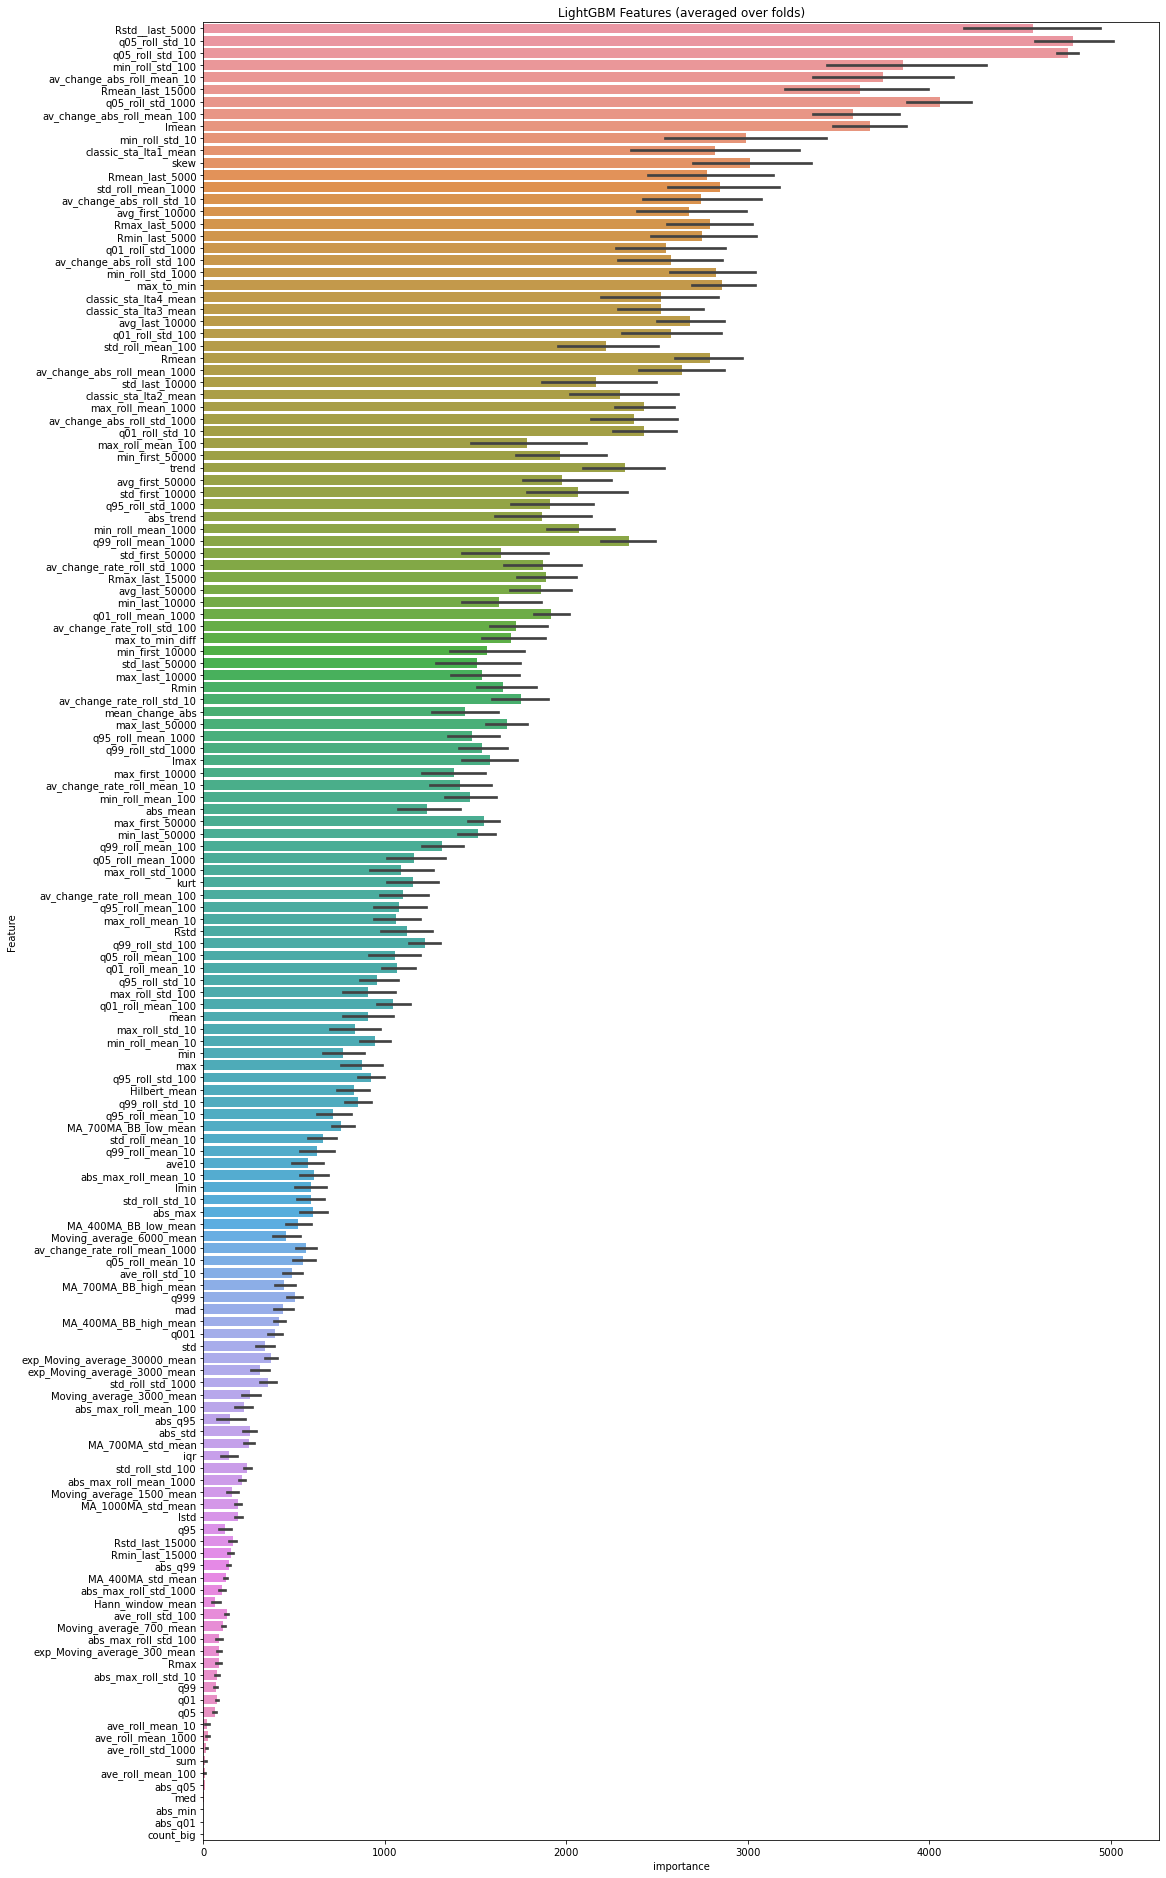

In [31]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
sns.barplot(x="importance", 
            y="Feature", 
            data=best_features.sort_values(by="importance",
                                           ascending=False))

### Submission

We set the predicted time to failure in the submission file:

In [60]:
my_submission.time_to_failure = predictions
my_submission.to_csv('submission_1.csv', index=True)

In [61]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [62]:
my_submission.head()

,time_to_failure
seg_id,
seg_00030f,8.900358
seg_0012b5,16.700522
seg_00184e,17.276203
seg_003339,25.203998
seg_0042cc,20.926705


In [64]:
score = mean_absolute_error(submission, my_submission)
print(f'MAE score: {score:0.4f}')

MAE score: 17.7644


### Model: NuSVR

Let's prepare and run the model:

In [50]:
%%time
svr = NuSVR()
svr.fit(scaled_train_X, train_y.values.flatten())

y_pred = svr.predict(scaled_train_X)

CPU times: user 4.17 s, sys: 53.7 ms, total: 4.23 s
Wall time: 4.27 s


Plot the graph:

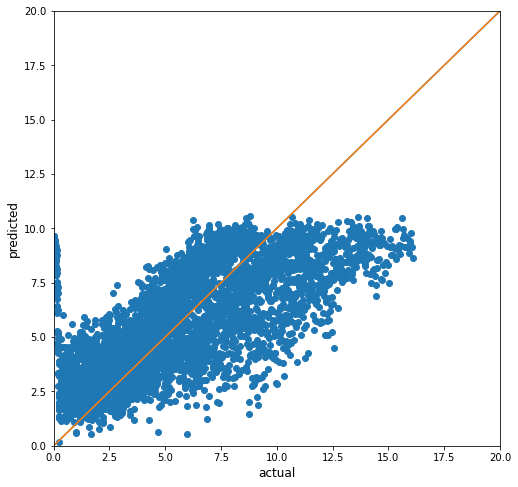

In [51]:
plt.figure(figsize=(8, 8))
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.scatter(train_y.values.flatten(), y_pred)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [53]:
score = mean_absolute_error(train_y.values.flatten(), y_pred)
print(f'MAE score: {score:0.4f}')

MAE score: 2.0195


### Submission

In [58]:
my_submission['time_to_failure'] = svr.predict(scaled_test_X)
my_submission.to_csv('submission_2.csv', index=True)

In [59]:
score = mean_absolute_error(submission, my_submission)
print(f'MAE score: {score:0.4f}')

MAE score: 5.7841
